In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Read images

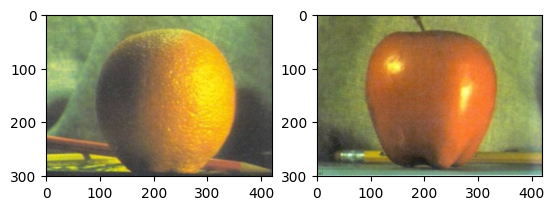

In [11]:
fig = plt.figure()

orange = cv2.imread("../../data/naranja.jpg")
o = fig.add_subplot(2,2,1)
o.imshow(cv2.cvtColor(orange, cv2.COLOR_BGR2RGB))

apple = cv2.imread("../../data/manzana.jpg")
a = fig.add_subplot(2,2,2)
a.imshow(cv2.cvtColor(apple, cv2.COLOR_BGR2RGB))

### Downsample image

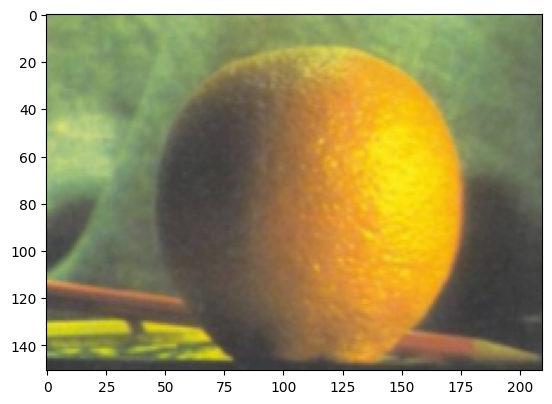

In [13]:
def downsample(img):
    return cv2.pyrDown(img)

little = downsample(orange)
plt.imshow(cv2.cvtColor(little, cv2.COLOR_BGR2RGB))
plt.show()


### Mask

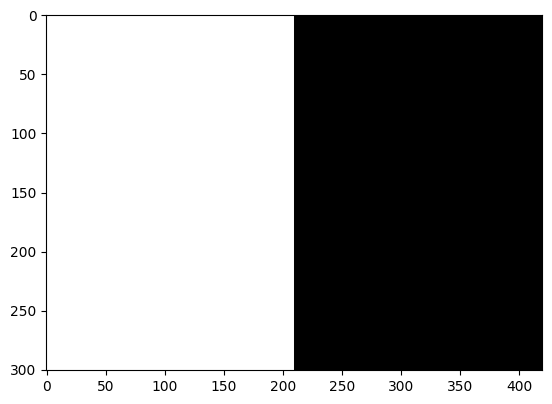

In [17]:
mask = np.ones((orange.shape))
mask[:, orange.shape[1] // 2:] = 0
plt.imshow(mask, cmap = "gray")